# Overview
SimpleITK, ITK, scipy, OpenCV, Tensorflow and PyTorch all offer tools for registering images, we explore a few here to see how well they work when applied to the fairly tricky problem of registering from the same person at different time and disease points.

In [30]:
import numpy as np # linear algebra
import tensorflow as tf # for tensorflow based registration
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch # for pytorch-based registration
import os
from cv2 import imread, createCLAHE # read and equalize images
import SimpleITK as sitk
import cv2
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

In [31]:
all_xray_df = pd.read_csv('../input/Data_Entry_2017.csv')
# la path= ../input/images/
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('..', 'input', 'images*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 4999 , Total Headers 112120


Image Index Finding Labels  Follow-up #  Patient ID  Patient Age  \
103189  00027502_000.png     No Finding            0       27502           33   
10692   00002763_037.png     No Finding           37        2763           53   
100493  00026651_000.png     No Finding            0       26651           49   

       Patient Gender View Position  OriginalImage[Width  Height]  \
103189              F            PA                 2654     2943   
10692               F            AP                 3056     2544   
100493              F            PA                 2992     2991   

        OriginalImagePixelSpacing[x     y]  Unnamed: 11  path  
103189                        0.143  0.143          NaN  None  
10692                         0.139  0.139          NaN  None  
100493                        0.143  0.143          NaN  None

array([[<AxesSubplot: title={'center': 'Follow-up #'}>,
        <AxesSubplot: title={'center': 'OriginalImagePixelSpacing[x'}>],
       [<AxesSubplot: title={'center': 'Patient Age'}>,
        <AxesSubplot: title={'center': 'OriginalImage[Width'}>]],
      dtype=object)

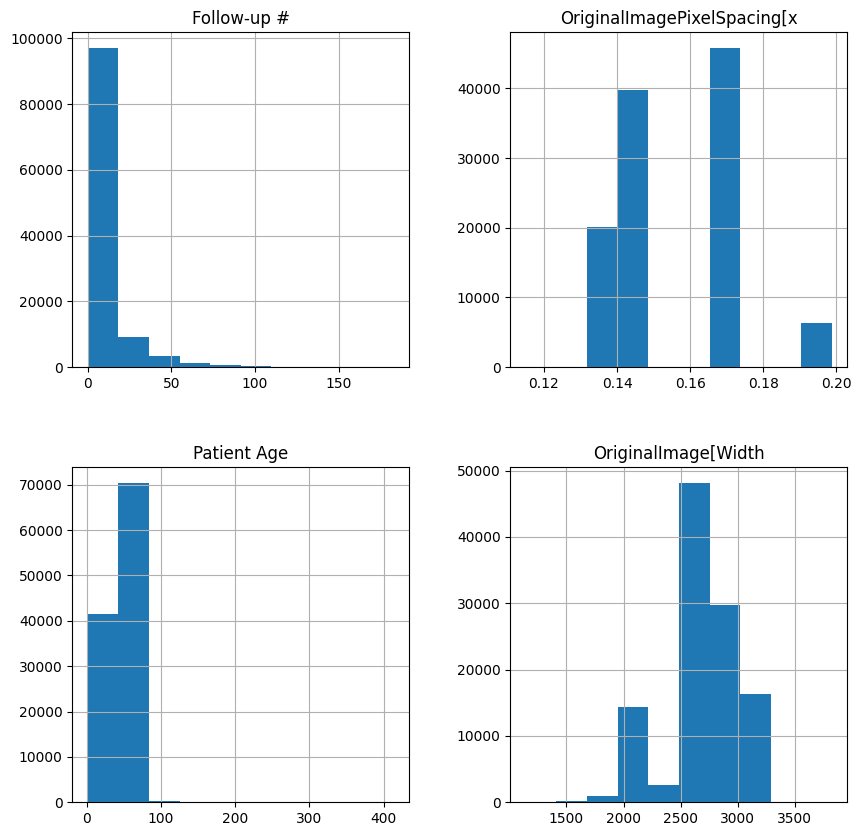

In [32]:
all_xray_df[['Follow-up #', 'OriginalImagePixelSpacing[x', 'Patient Age', 'OriginalImage[Width']].hist(figsize = (10, 10))

In [33]:
all_xray_df[['View Position', 'Patient Gender']].describe().T

count unique top   freq
View Position   112120      2  PA  67310
Patient Gender  112120      2   M  63340

# Select Frequent Flyers

Image Index                         Finding Labels  Follow-up #  \
38  00000013_000.png                             No Finding            0   
52  00000013_014.png                             No Finding           14   
53  00000013_015.png                             No Finding           15   
54  00000013_016.png                             No Finding           16   
55  00000013_017.png                             No Finding           17   
57  00000013_019.png                             No Finding           19   
58  00000013_020.png                           Pneumothorax           20   
59  00000013_021.png                               Effusion           21   
60  00000013_022.png                      Infiltration|Mass           22   
63  00000013_025.png  Cardiomegaly|Infiltration|Mass|Nodule           25   

    Patient ID  Patient Age Patient Gender View Position  OriginalImage[Width  \
38          13           61              M            PA                 2021   
52          13           61              M            PA                 2021   
53          13           61              M            PA                 2020   
54          13           61              M            PA                 1725   
55          13           61              M            PA                 2021   
57          13           62              M            PA                 2021   
58          13           62              M            PA                 2021   
59          13           62              M            PA                 2021   
60          13           56              M            PA                 2870   
63          13           56              M            PA                 2992   

    Height]  OriginalImagePixelSpacing[x        y]  Unnamed: 11  \
38     2021                     0.194311  0.194311          NaN   
52     2021                     0.194311  0.194311          NaN   
53     2021                     0.194311  0.194311          NaN   
54     2021                     0.194311  0.194311          NaN   
55     2021                     0.194311  0.194311          NaN   
57     2021                     0.194311  0.194311          NaN   
58     2021                     0.194311  0.194311          NaN   
59     2021                     0.194311  0.194311          NaN   
60     2991                     0.143000  0.143000          NaN   
63     2991                     0.143000  0.143000          NaN   

                                path  
38  ..\input\images\00000013_000.png  
52  ..\input\images\00000013_014.png  
53  ..\input\images\00000013_015.png  
54  ..\input\images\00000013_016.png  
55  ..\input\images\00000013_017.png  
57  ..\input\images\00000013_019.png  
58  ..\input\images\00000013_020.png  
59  ..\input\images\00000013_021.png  
60  ..\input\images\00000013_022.png  
63  ..\input\images\00000013_025.png

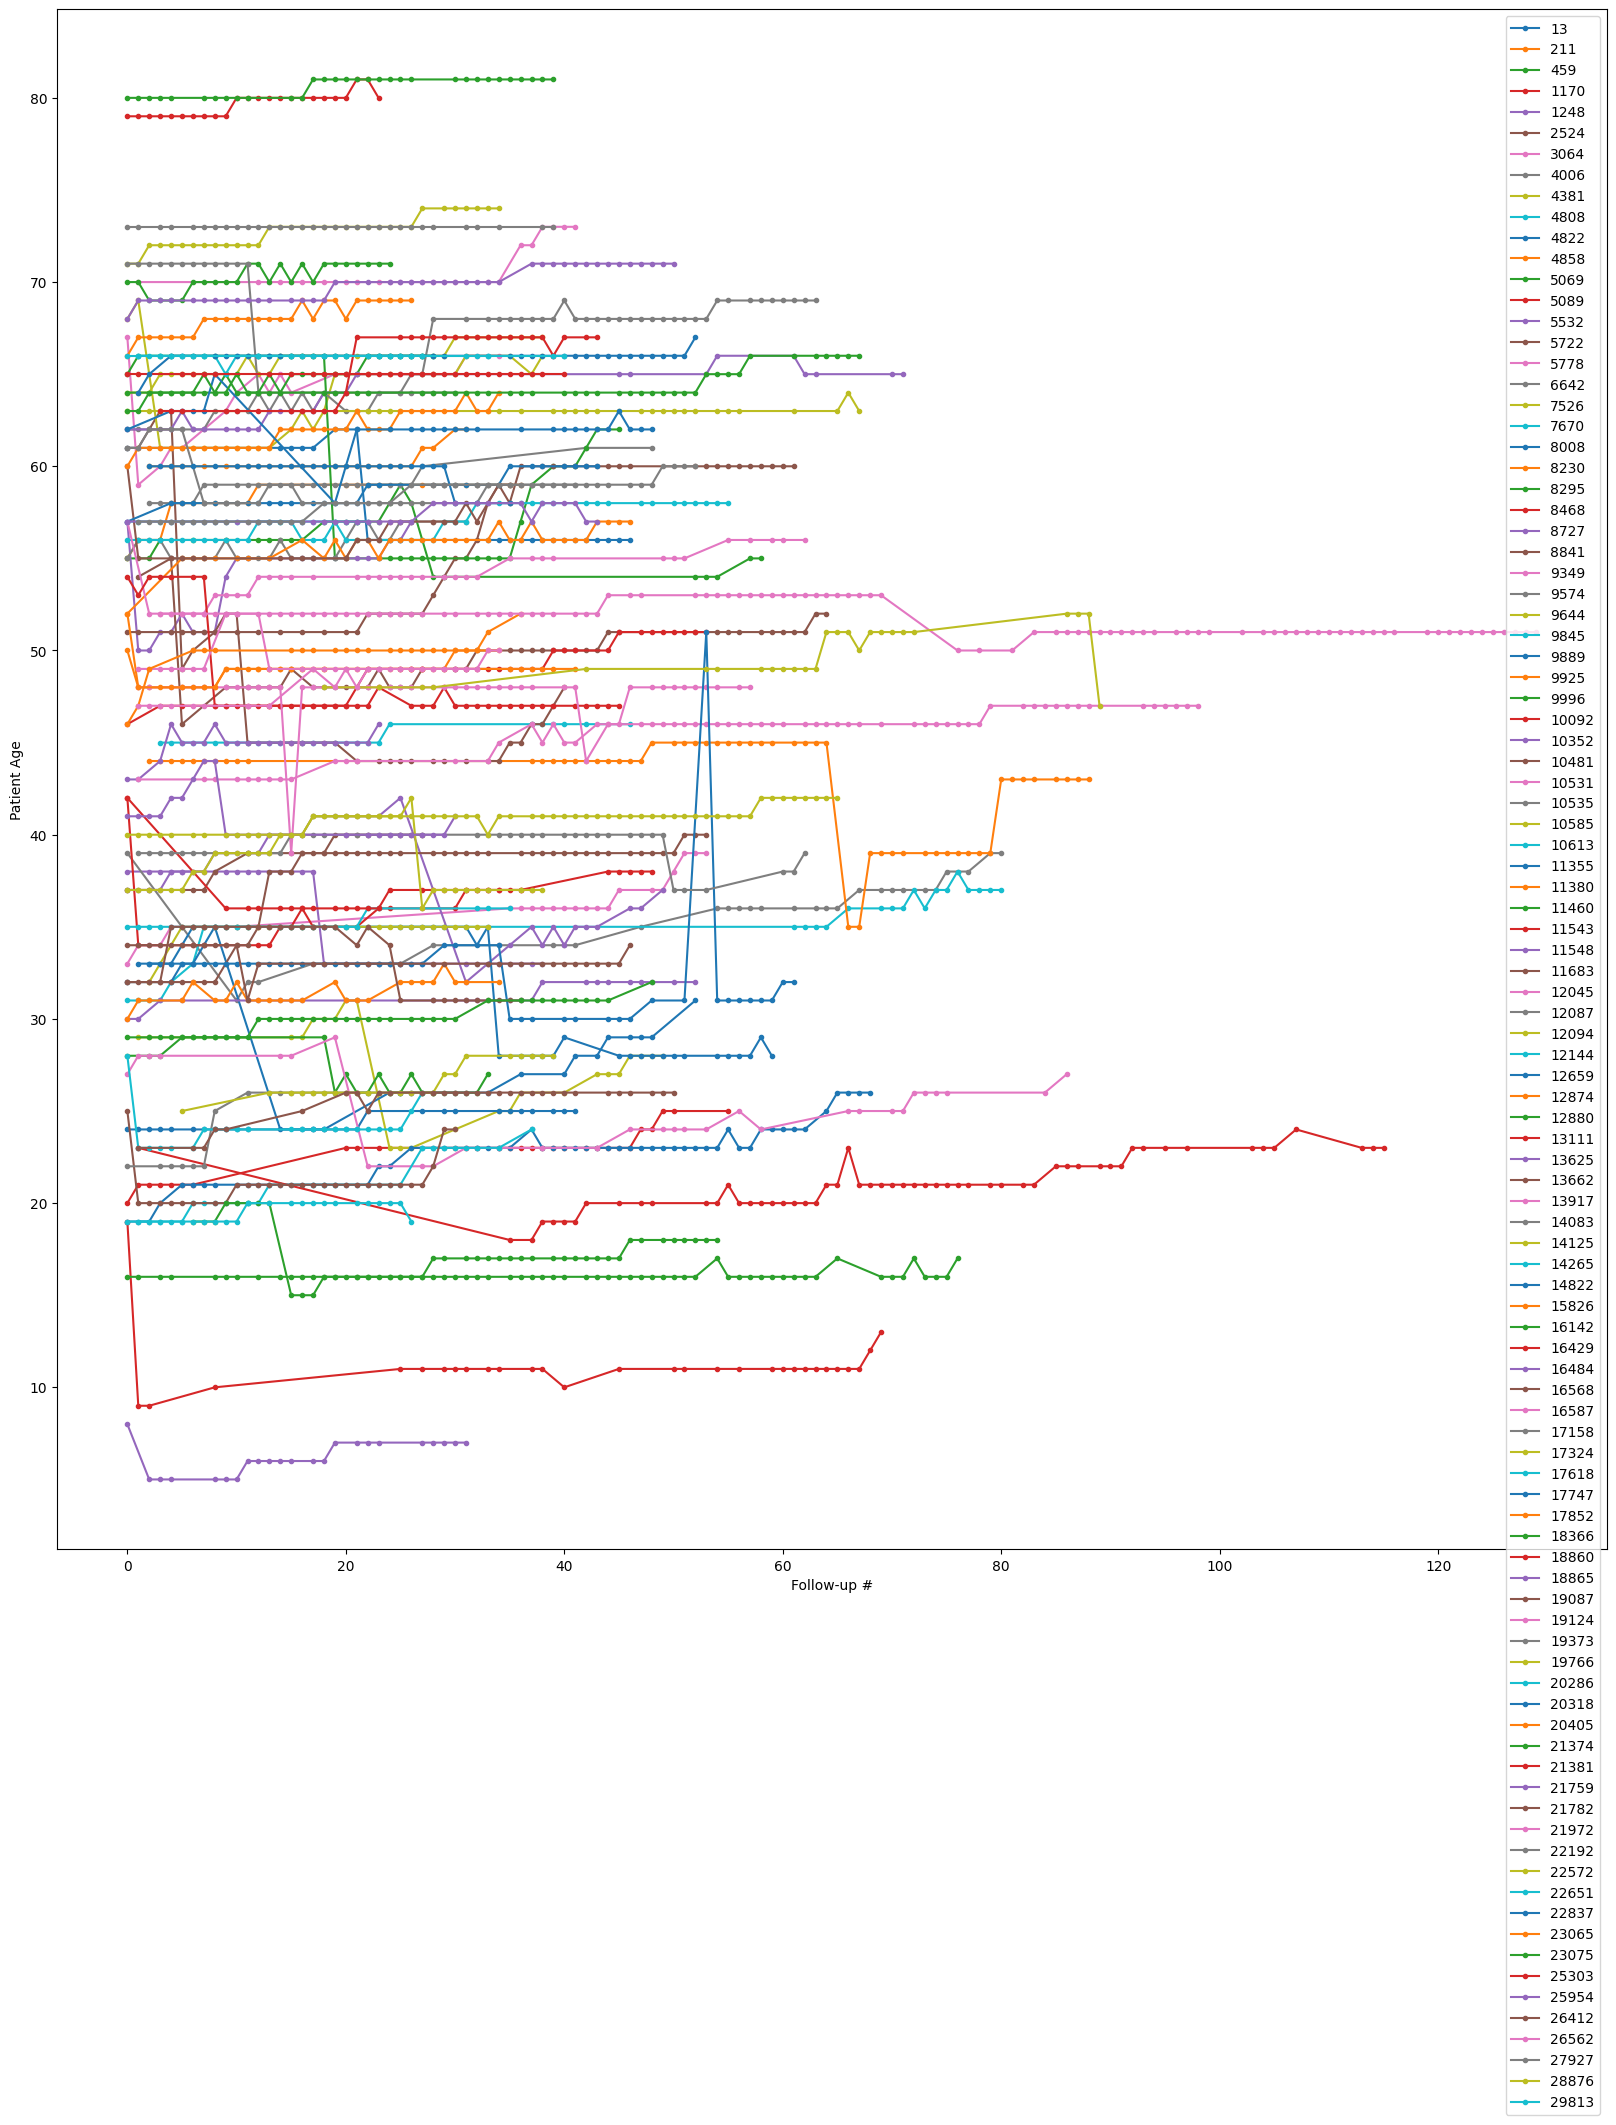

In [34]:
pa_xray_df = all_xray_df[all_xray_df['View Position'].isin(['PA'])].copy()
pa_xray_df = pa_xray_df[pa_xray_df['Patient Age']<120]
top_patients_df = pa_xray_df.groupby(['Patient ID']
                                    ).count()[['Image Index']].reset_index().sort_values('Image Index', ascending = False).head(100)
pa_xray_df = pa_xray_df[pa_xray_df['Patient ID'].isin(top_patients_df['Patient ID'].values)].sort_values(['Patient ID', 'Follow-up #'])
fig, ax1 = plt.subplots(1,1, figsize = (20, 20))
for p_id, c_rows in pa_xray_df.groupby('Patient ID'):
    ax1.plot(c_rows['Follow-up #'], c_rows['Patient Age'], '.-', label = p_id)
ax1.legend()
ax1.set_xlabel('Follow-up #')
ax1.set_ylabel('Patient Age')
pa_xray_df.head(10)


In [35]:
from skimage.transform import resize
OUT_DIM = (512, 512)
def simple_imread(im_path, apply_clahe = False):
    img_data = np.mean(imread(im_path), 2).astype(np.uint8)
    n_img = (255*resize(img_data, OUT_DIM, mode = 'constant')).clip(0,255).astype(np.uint8)
    if apply_clahe:
        clahe_tool = createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        return clahe_tool.apply(n_img)
    else:
        return n_img

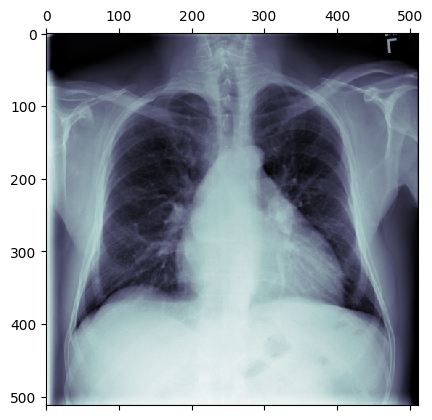

In [36]:
test_img = simple_imread(all_xray_df['path'].values[0])
plt.matshow(test_img, cmap = 'bone')

In [37]:
# grab the scans from the first patient
first_patient_df = pa_xray_df[pa_xray_df['Patient ID'].isin([pa_xray_df['Patient ID'].values[0]])]
print(first_patient_df.shape[0], 'scans found')
first_patient_df.head(10)

24 scans found


Image Index                         Finding Labels  Follow-up #  \
38  00000013_000.png                             No Finding            0   
52  00000013_014.png                             No Finding           14   
53  00000013_015.png                             No Finding           15   
54  00000013_016.png                             No Finding           16   
55  00000013_017.png                             No Finding           17   
57  00000013_019.png                             No Finding           19   
58  00000013_020.png                           Pneumothorax           20   
59  00000013_021.png                               Effusion           21   
60  00000013_022.png                      Infiltration|Mass           22   
63  00000013_025.png  Cardiomegaly|Infiltration|Mass|Nodule           25   

    Patient ID  Patient Age Patient Gender View Position  OriginalImage[Width  \
38          13           61              M            PA                 2021   
52          13           61              M            PA                 2021   
53          13           61              M            PA                 2020   
54          13           61              M            PA                 1725   
55          13           61              M            PA                 2021   
57          13           62              M            PA                 2021   
58          13           62              M            PA                 2021   
59          13           62              M            PA                 2021   
60          13           56              M            PA                 2870   
63          13           56              M            PA                 2992   

    Height]  OriginalImagePixelSpacing[x        y]  Unnamed: 11  \
38     2021                     0.194311  0.194311          NaN   
52     2021                     0.194311  0.194311          NaN   
53     2021                     0.194311  0.194311          NaN   
54     2021                     0.194311  0.194311          NaN   
55     2021                     0.194311  0.194311          NaN   
57     2021                     0.194311  0.194311          NaN   
58     2021                     0.194311  0.194311          NaN   
59     2021                     0.194311  0.194311          NaN   
60     2991                     0.143000  0.143000          NaN   
63     2991                     0.143000  0.143000          NaN   

                                path  
38  ..\input\images\00000013_000.png  
52  ..\input\images\00000013_014.png  
53  ..\input\images\00000013_015.png  
54  ..\input\images\00000013_016.png  
55  ..\input\images\00000013_017.png  
57  ..\input\images\00000013_019.png  
58  ..\input\images\00000013_020.png  
59  ..\input\images\00000013_021.png  
60  ..\input\images\00000013_022.png  
63  ..\input\images\00000013_025.png

In [38]:
%%time
first_scans = np.stack(first_patient_df['path'].map(simple_imread).values,0)

CPU times: total: 3.89 s
Wall time: 5.87 s


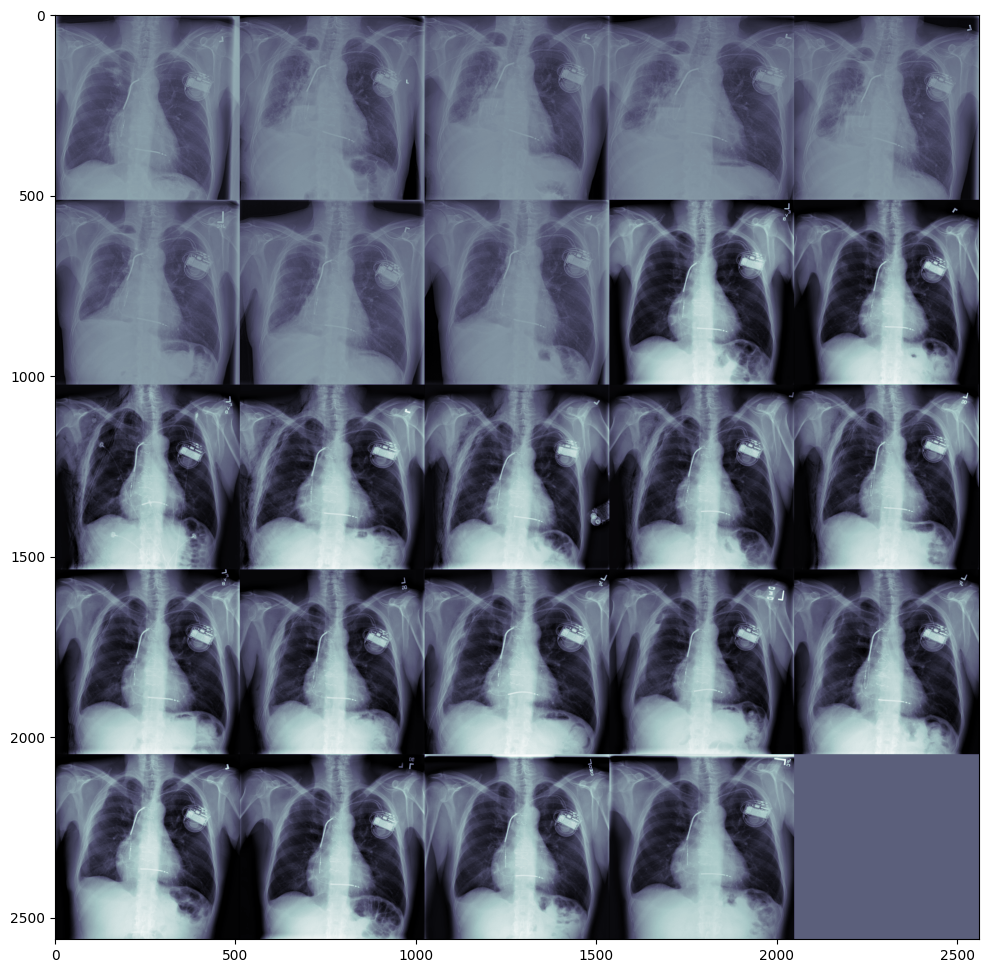

In [39]:
# might as well show-em if we have em
from skimage.util._montage import montage
fig, ax1 = plt.subplots(1,1, figsize = (12,12))
ax1.imshow(montage(first_scans), cmap = 'bone')
fig.savefig('overview.png', dpi = 300)

# Registration Problem
We would like to register the two images so we can focus on the differences. In the example below we try to subtract the two scans and the difference image has lots of structures from the original image visible not just the differences

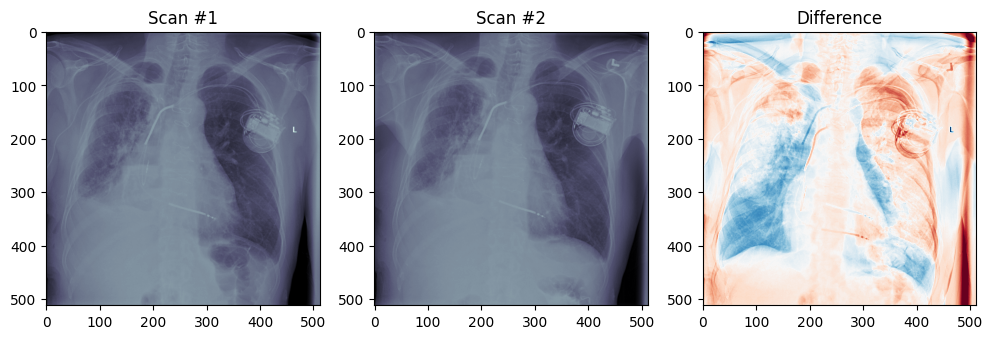

In [40]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 4))
ax1.imshow(first_scans[1], cmap = 'bone', vmax = 255)
ax1.set_title('Scan #1')
ax2.imshow(first_scans[2], cmap = 'bone', vmax = 255)
ax2.set_title('Scan #2')
ax3.imshow(1.0*first_scans[1]-first_scans[0], vmin = -100, vmax = 100, cmap = 'RdBu')
ax3.set_title('Difference');

# OpenCV Approach
The easiest and oldest method is the OpenCV-based approach to find similar points on the images and match them up. A more detailed tutorial is available here: http://www.learnopencv.com/image-alignment-feature-based-using-opencv-c-python/

In [41]:
import cv2
MAX_FEATURES = 1000
GOOD_MATCH_PERCENT = 0.20
def alignImages(im1Gray, im2Gray):
    # Detect ORB features and compute descriptors.
    orb = cv2.ORB_create(MAX_FEATURES)
    keypoints1, descriptors1 = orb.detectAndCompute(im1Gray, None)
    keypoints2, descriptors2 = orb.detectAndCompute(im2Gray, None)
    # Match features.
    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = matcher.match(descriptors1, descriptors2, None)
    # Sort matches by score
    sorted(matches,key=lambda x: x.distance, reverse=False)
    # Remove not so good matches
    numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
    matches = matches[:numGoodMatches]
    # Draw top matches
    imMatches = cv2.drawMatches(im1Gray, keypoints1, im2Gray, keypoints2, matches, None)
    fig, ax1 = plt.subplots(1,1, figsize = (8,8))
    ax1.imshow(imMatches)
    # Extract location of good matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)
    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt
    # Find homography
    h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)
    # Use homography
    height, width = im2Gray.shape
    im1Reg = cv2.warpPerspective(im1Gray, h, (width, height))
    return im1Reg, h

CPU times: total: 78.1 ms
Wall time: 88.9 ms


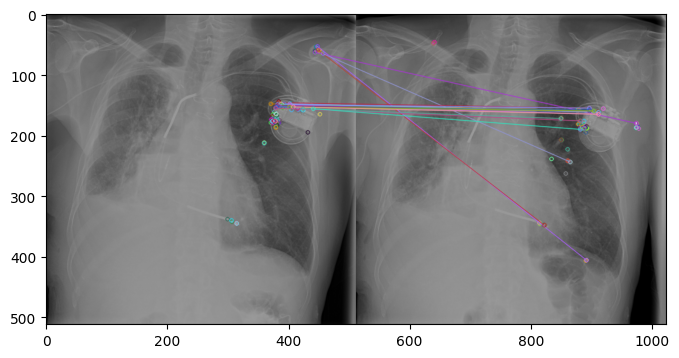

In [42]:
%%time
registered_scan_2, _ = alignImages(first_scans[2], first_scans[1])

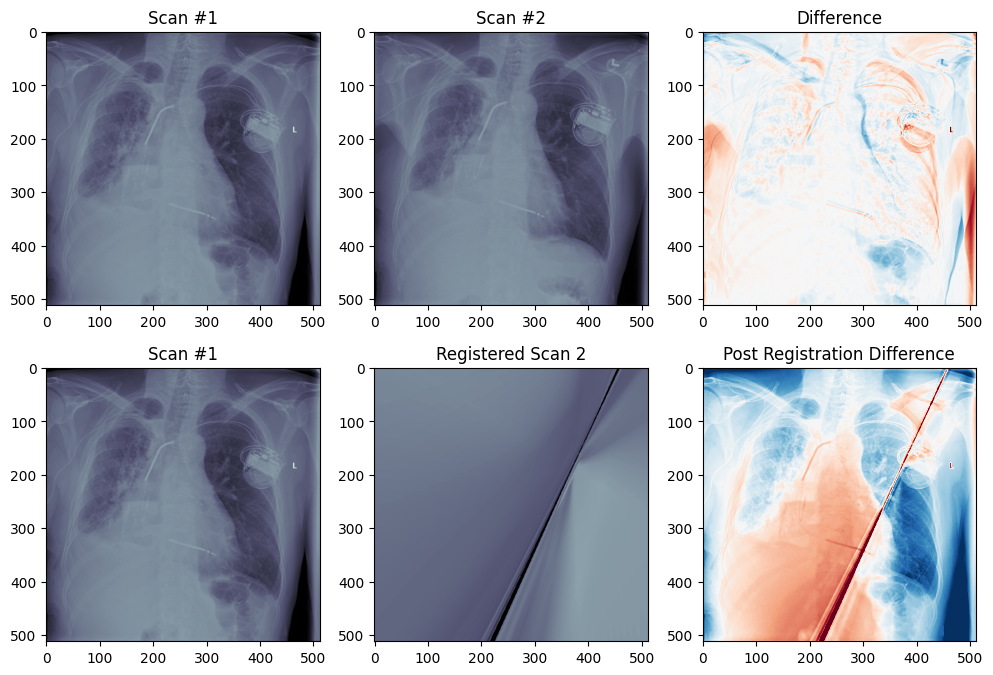

In [43]:
fig, ((ax1, ax2, ax3), (ax1a, ax4, ax5)) = plt.subplots(2, 3, figsize = (12, 8))
ax1.imshow(first_scans[1], cmap = 'bone', vmax = 255)
ax1.set_title('Scan #1')
ax2.imshow(first_scans[2], cmap = 'bone', vmax = 255)
ax2.set_title('Scan #2')
ax3.imshow(1.0*first_scans[2]-first_scans[1], vmin = -100, vmax = 100, cmap = 'RdBu')
ax3.set_title('Difference')
ax1a.imshow(first_scans[1], cmap = 'bone', vmax = 255)
ax1a.set_title('Scan #1')
ax4.imshow(registered_scan_2, cmap = 'bone', vmax = 255)
ax4.set_title('Registered Scan 2')
ax5.imshow(1.0*registered_scan_2-first_scans[1], vmin = -100, vmax = 100, cmap = 'RdBu')
ax5.set_title('Post Registration Difference');

# SimpleITK Approach
Here we use the tools of SimpleITK to register the two chest x-ray scans.

In [44]:
def register_img(fixed_arr, 
                 moving_arr,
                use_affine = True,
                use_mse = True,
                brute_force = True,
                show_transform = True):
    fixed_image = sitk.GetImageFromArray(fixed_arr)
    moving_image = sitk.GetImageFromArray(moving_arr)
    transform = sitk.AffineTransform(2) if use_affine else sitk.ScaleTransform(2)
    initial_transform = sitk.CenteredTransformInitializer(sitk.Cast(fixed_image,moving_image.GetPixelID()), 
                                                      moving_image, 
                                                      transform, 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)
    ff_img = sitk.Cast(fixed_image, sitk.sitkFloat32)
    mv_img = sitk.Cast(moving_image, sitk.sitkFloat32)
    registration_method = sitk.ImageRegistrationMethod()
    if use_mse:
        registration_method.SetMetricAsMeanSquares()
    else:
        registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    
    if brute_force:
        sample_per_axis = 12
        registration_method.SetOptimizerAsExhaustive([sample_per_axis//2,0,0])
        # Utilize the scale to set the step size for each dimension
        registration_method.SetOptimizerScales([2.0*3.14/sample_per_axis, 1.0,1.0])
    else:
        registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
        registration_method.SetMetricSamplingPercentage(0.25)

    registration_method.SetInterpolator(sitk.sitkLinear)

    registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, 
                                                      numberOfIterations=200, 
                                                      convergenceMinimumValue=1e-6,
                                                      convergenceWindowSize=10)
    # Scale the step size differently for each parameter, this is critical!!!
    registration_method.SetOptimizerScalesFromPhysicalShift() 

    registration_method.SetInitialTransform(initial_transform, inPlace=False)
    final_transform_v1 = registration_method.Execute(ff_img, 
                                                     mv_img)
    print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))
    print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
    resample = sitk.ResampleImageFilter()
    resample.SetReferenceImage(fixed_image)
    
    # SimpleITK supports several interpolation options, we go with the simplest that gives reasonable results.     
    resample.SetInterpolator(sitk.sitkBSpline)  
    resample.SetTransform(final_transform_v1)
    if show_transform:
        fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 6))
        xx, yy = np.meshgrid(range(moving_arr.shape[0]), range(moving_arr.shape[1]))
        test_pattern = (((xx % 40)>30)|((yy % 40)>30)).astype(np.float32)
        ax1.imshow(test_pattern, cmap = 'bone_r')
        ax1.set_title('Test Pattern')
        test_pattern_img = sitk.GetImageFromArray(test_pattern)
        skew_pattern = sitk.GetArrayFromImage(resample.Execute(test_pattern_img))
        ax2.imshow(skew_pattern, cmap = 'bone_r')
        ax2.set_title('Registered Pattern')
    return sitk.GetArrayFromImage(resample.Execute(moving_image))

Optimizer's stopping condition, GradientDescentOptimizerv4Template: Maximum number of iterations (200) exceeded.
Final metric value: 100.95856504114768
CPU times: total: 39 s
Wall time: 11.8 s


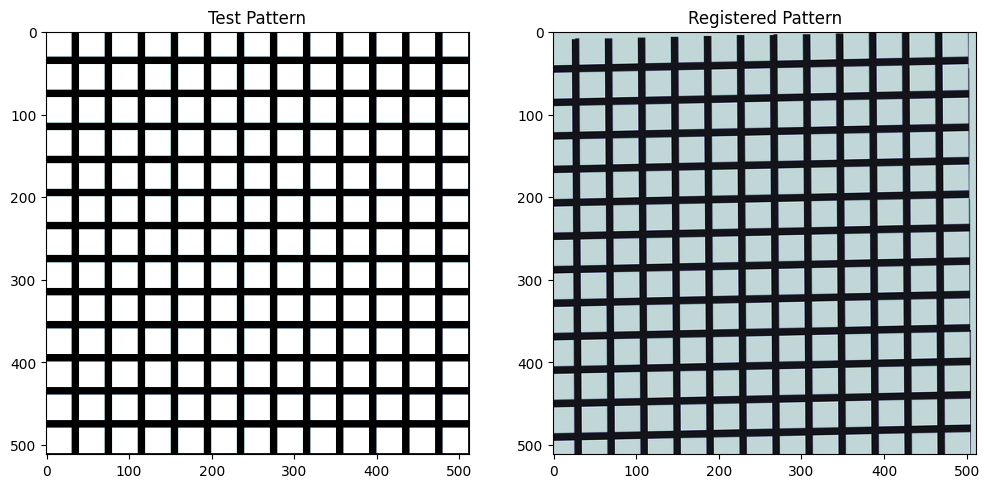

In [45]:
%%time
registered_scan_2 = register_img(first_scans[1], first_scans[2])

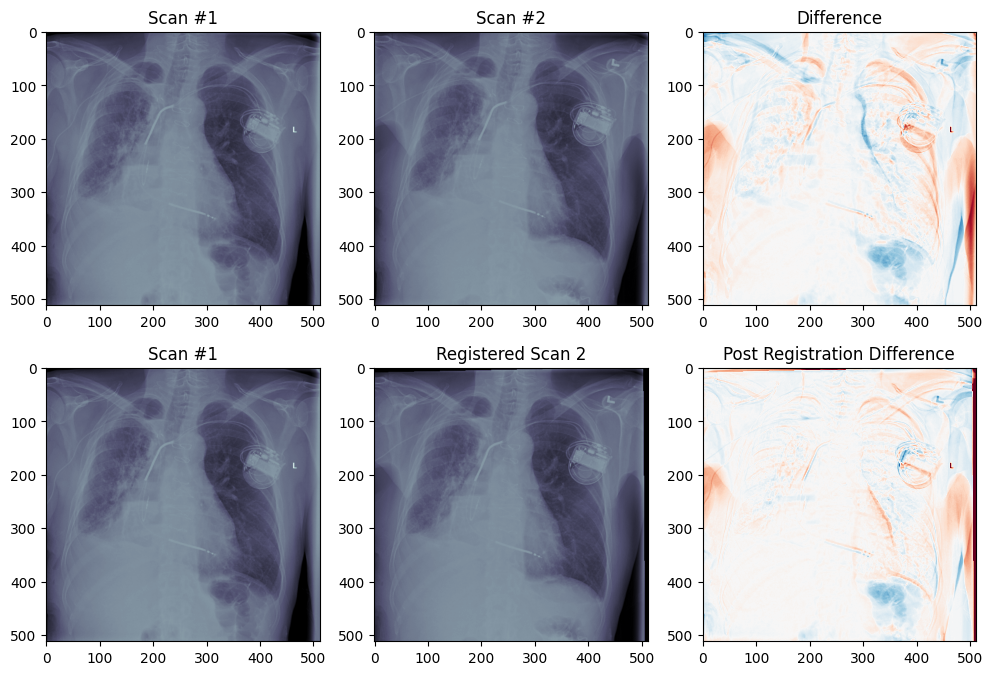

In [46]:
fig, ((ax1, ax2, ax3), (ax1a, ax4, ax5)) = plt.subplots(2, 3, figsize = (12, 8))
ax1.imshow(first_scans[1], cmap = 'bone', vmax = 255)
ax1.set_title('Scan #1')
ax2.imshow(first_scans[2], cmap = 'bone', vmax = 255)
ax2.set_title('Scan #2')
ax3.imshow(1.0*first_scans[2]-first_scans[1], vmin = -100, vmax = 100, cmap = 'RdBu')
ax3.set_title('Difference')
ax1a.imshow(first_scans[1], cmap = 'bone', vmax = 255)
ax1a.set_title('Scan #1')
ax4.imshow(registered_scan_2, cmap = 'bone', vmax = 255)
ax4.set_title('Registered Scan 2')
ax5.imshow(1.0*registered_scan_2-first_scans[1], vmin = -100, vmax = 100, cmap = 'RdBu')
ax5.set_title('Post Registration Difference');

# SimpleITK Deformable Approach
We can apply deformable approaches to the same problem using some of the example code given in http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/65_Registration_FFD.html

In [47]:
def register_img_generic(fixed_arr, 
                 moving_arr,
                registration_func,
                        show_transform = True):
    fixed_image = sitk.GetImageFromArray(fixed_arr)
    moving_image = sitk.GetImageFromArray(moving_arr)
    ff_img = sitk.Cast(fixed_image, sitk.sitkFloat32)
    mv_img = sitk.Cast(moving_image, sitk.sitkFloat32)
    
    final_transform_v1 = registration_func(ff_img, mv_img)
    resample = sitk.ResampleImageFilter()
    resample.SetReferenceImage(fixed_image)
    
    # SimpleITK supports several interpolation options, we go with the simplest that gives reasonable results.     
    resample.SetInterpolator(sitk.sitkBSpline)  
    resample.SetTransform(final_transform_v1)
    if show_transform:
        fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 6))
        xx, yy = np.meshgrid(range(moving_arr.shape[0]), range(moving_arr.shape[1]))
        test_pattern = (((xx % 40)>30)|((yy % 40)>30)).astype(np.float32)
        ax1.imshow(test_pattern, cmap = 'bone_r')
        ax1.set_title('Test Pattern')
        test_pattern_img = sitk.GetImageFromArray(test_pattern)
        skew_pattern = sitk.GetArrayFromImage(resample.Execute(test_pattern_img))
        ax2.imshow(skew_pattern, cmap = 'bone_r')
        ax2.set_title('Registered Pattern')
    return sitk.GetArrayFromImage(resample.Execute(moving_image))

def bspline_intra_modal_registration(fixed_image, moving_image, grid_physical_spacing =  [15.0]*3):
    registration_method = sitk.ImageRegistrationMethod()
    # Determine the number of BSpline control points using the physical spacing we want for the control grid. 
    image_physical_size = [size*spacing for size,spacing in zip(fixed_image.GetSize(), fixed_image.GetSpacing())]
    mesh_size = [int(image_size/grid_spacing + 0.5) \
                 for image_size,grid_spacing in zip(image_physical_size,grid_physical_spacing)]
    print('Using Mesh Size', mesh_size)
    initial_transform = sitk.BSplineTransformInitializer(image1 = fixed_image, 
                                                         transformDomainMeshSize = mesh_size, order=3)    
    registration_method.SetInitialTransform(initial_transform)
        
    registration_method.SetMetricAsMeanSquares()
    # Settings for metric sampling, usage of a mask is optional. When given a mask the sample points will be 
    # generated inside that region. Also, this implicitly speeds things up as the mask is smaller than the
    # whole image.
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.01)
    
    # Multi-resolution framework.            
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    registration_method.SetInterpolator(sitk.sitkLinear)
    registration_method.SetOptimizerAsLBFGSB(gradientConvergenceTolerance=1e-5, numberOfIterations=100)
    return registration_method.Execute(fixed_image, moving_image)

Using Mesh Size [34, 34]
CPU times: total: 24.3 s
Wall time: 8.33 s


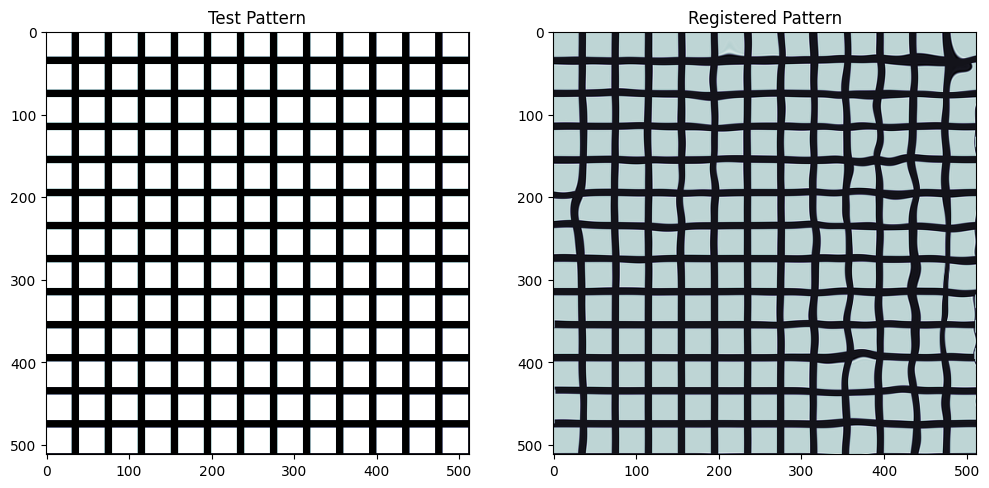

In [48]:
%%time
dregistered_scan_2 = register_img_generic(first_scans[1], registered_scan_2, registration_func=bspline_intra_modal_registration)

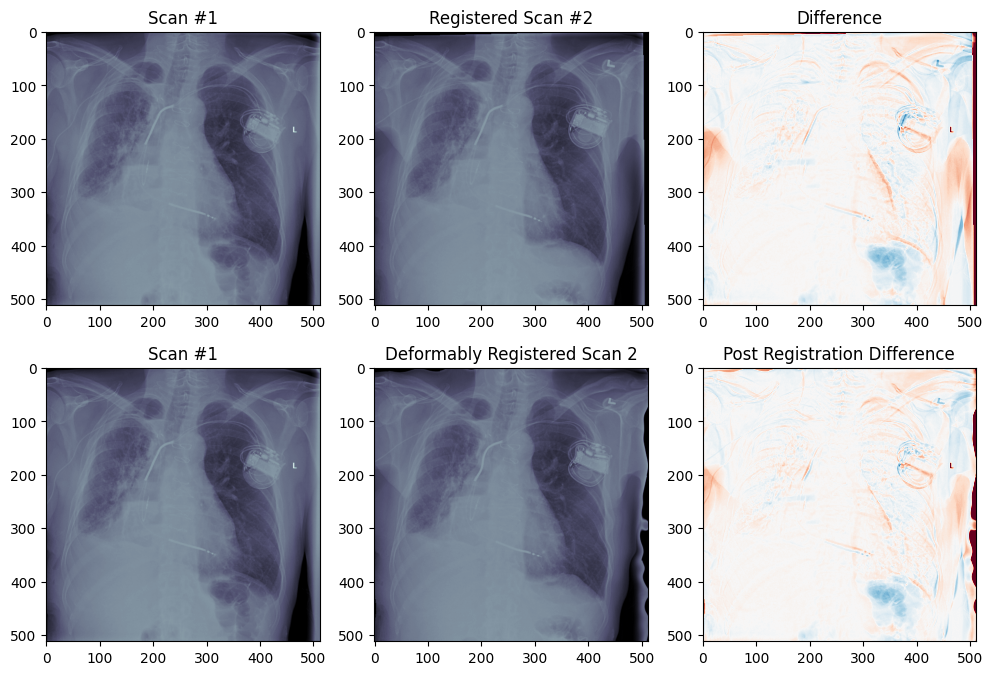

In [49]:
fig, ((ax1, ax2, ax3), (ax1a, ax4, ax5)) = plt.subplots(2, 3, figsize = (12, 8))
ax1.imshow(first_scans[1], cmap = 'bone', vmax = 255)
ax1.set_title('Scan #1')
ax2.imshow(registered_scan_2, cmap = 'bone', vmax = 255)
ax2.set_title('Registered Scan #2')
ax3.imshow(1.0*registered_scan_2-first_scans[1], vmin = -100, vmax = 100, cmap = 'RdBu')
ax3.set_title('Difference')
ax1a.imshow(first_scans[1], cmap = 'bone', vmax = 255)
ax1a.set_title('Scan #1')
ax4.imshow(dregistered_scan_2, cmap = 'bone', vmax = 255)
ax4.set_title('Deformably Registered Scan 2')
ax5.imshow(1.0*dregistered_scan_2-first_scans[1], vmin = -100, vmax = 100, cmap = 'RdBu')
ax5.set_title('Post Registration Difference');

# PyTorch Approach
PyTorch is well suited to these kind of optimization problems since like Tensorflow it is designed for performant computations on tensors and has predefined operations to handle gradient descent, spatial transformations, and other important functions. We use the [Spatial Transformer tutorial](https://pytorch.org/tutorials/intermediate/spatial_transformer_tutorial.html) by Ghassen Hamrouni as a baseline for the example here. 

In [50]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.nn.parameter import Parameter
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [51]:
class SimpleAffineRegistration(nn.Module):
    def __init__(self):
        super(SimpleAffineRegistration, self).__init__()
        self.theta = Parameter(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float).view(2,3))
    # Spatial transformer network forward function
    def stn(self, x, theta):
        theta_vec = theta.repeat((x.shape[0], 1, 1))
        grid = F.affine_grid(theta_vec, x.size())
        return F.grid_sample(x, grid)

    def forward(self, x):
        # transform the input
        return self.stn(x, self.theta)

model = SimpleAffineRegistration().to(device)

# Setup the Tensors
Here we setup the tensors and show the model appears to work for the basic no deformation case**

In [52]:
moving_tensor = torch.tensor(np.expand_dims(np.expand_dims(first_scans[2],0), -1)/255.0, dtype = torch.float)
fixed_tensor = torch.tensor(np.expand_dims(np.expand_dims(first_scans[1],0), -1)/255.0, dtype = torch.float)

In [53]:
torch_registered_scan_2 = model.forward(moving_tensor)
t_img = 255.0*torch_registered_scan_2.detach().numpy()[0,:,:,0]

c:\Users\Republic Of Computer\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\functional.py:4289: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
c:\Users\Republic Of Computer\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


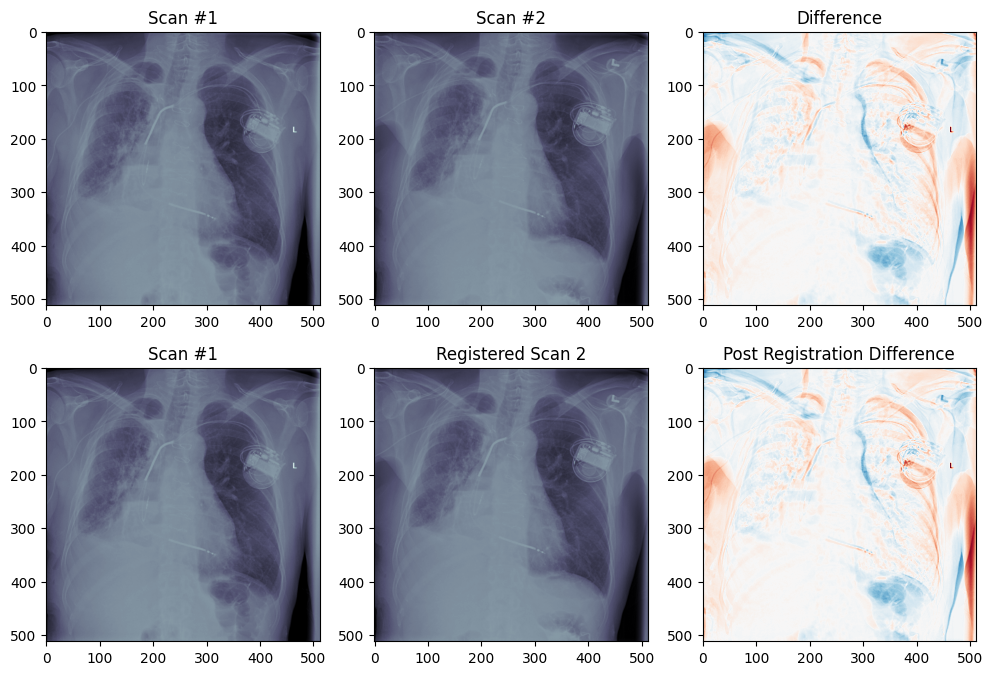

In [54]:
fig, ((ax1, ax2, ax3), (ax1a, ax4, ax5)) = plt.subplots(2, 3, figsize = (12, 8))
ax1.imshow(first_scans[1], cmap = 'bone', vmax = 255)
ax1.set_title('Scan #1')
ax2.imshow(first_scans[2], cmap = 'bone', vmax = 255)
ax2.set_title('Scan #2')
ax3.imshow(1.0*first_scans[2]-first_scans[1], vmin = -100, vmax = 100, cmap = 'RdBu')
ax3.set_title('Difference')
ax1a.imshow(first_scans[1], cmap = 'bone', vmax = 255)
ax1a.set_title('Scan #1')
ax4.imshow(t_img, cmap = 'bone', vmax = 255)
ax4.set_title('Registered Scan 2')
ax5.imshow(t_img-first_scans[1], vmin = -100, vmax = 100, cmap = 'RdBu')
ax5.set_title('Post Registration Difference');

Train Epoch: 0	Loss: 0.003062
Train Epoch: 10	Loss: 0.002986
Train Epoch: 20	Loss: 0.002961
Train Epoch: 30	Loss: 0.002935
Train Epoch: 40	Loss: 0.002911
Train Epoch: 50	Loss: 0.002897
Train Epoch: 60	Loss: 0.002881
Train Epoch: 70	Loss: 0.002867
Train Epoch: 80	Loss: 0.002857
Train Epoch: 90	Loss: 0.002849
Final Parameters [Parameter containing:
tensor([[ 1.0000e+00, -4.0709e-05,  7.0156e-04],
        [ 0.0000e+00,  9.9340e-01,  7.1335e-03]], requires_grad=True)]


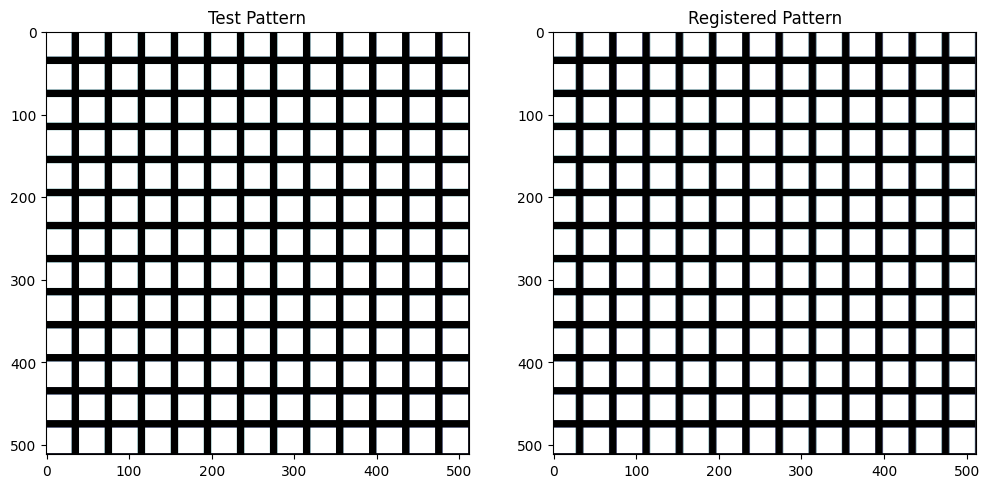

In [55]:
optimizer = optim.SGD(model.parameters(), lr=5e-3)
for epoch in range(100):
    optimizer.zero_grad()
    torch_registered_scan_2 = model.forward(moving_tensor)
    loss = F.mse_loss(torch_registered_scan_2, fixed_tensor)
    loss.backward()
    optimizer.step()
    if (epoch % 10)==0:
        print('Train Epoch: {}\tLoss: {:.6f}'.format(epoch, loss.item()))
print('Final Parameters', list(model.parameters()))

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 6))
xx, yy = np.meshgrid(range(first_scans[1].shape[0]), range(first_scans[1].shape[1]))
test_pattern = (((xx % 40)>30)|((yy % 40)>30)).astype(np.float32)
ax1.imshow(test_pattern, cmap = 'bone_r')
ax1.set_title('Test Pattern')
test_tensor = torch.tensor(np.expand_dims(np.expand_dims(test_pattern, 0), -1), dtype = torch.float)
skew_pattern = model.forward(test_tensor).detach().numpy()[0,:,:,0]
ax2.imshow(skew_pattern, cmap = 'bone_r')
ax2.set_title('Registered Pattern');

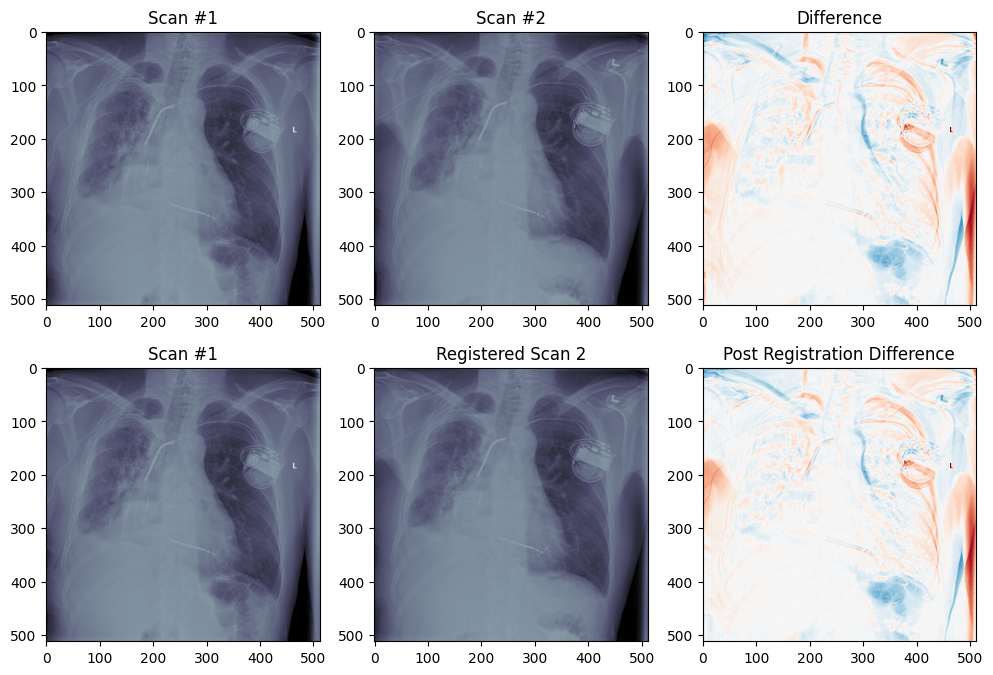

In [56]:
fig, ((ax1, ax2, ax3), (ax1a, ax4, ax5)) = plt.subplots(2, 3, figsize = (12, 8))
ax1.imshow(first_scans[1], cmap = 'bone', vmax = 255)
ax1.set_title('Scan #1')
ax2.imshow(first_scans[2], cmap = 'bone', vmax = 255)
ax2.set_title('Scan #2')
ax3.imshow(1.0*first_scans[2]-first_scans[1], vmin = -100, vmax = 100, cmap = 'RdBu')
ax3.set_title('Difference')
ax1a.imshow(first_scans[1], cmap = 'bone', vmax = 255)
ax1a.set_title('Scan #1')
t_img = 255.0*torch_registered_scan_2.detach().numpy()[0,:,:,0]
ax4.imshow(t_img, cmap = 'bone', vmax = 255)
ax4.set_title('Registered Scan 2')
ax5.imshow(t_img-first_scans[1], vmin = -100, vmax = 100, cmap = 'RdBu')
ax5.set_title('Post Registration Difference');

# Tensorflow Approach
Here we use tensorflow to approach the same problem. Tensorflow is much more flexible and allows us to try a number of different loss and registration approaches, but we have to code quite a bit by hand

In [67]:
"""
Code taken from https://github.com/kevinzakka/spatial-transformer-network/blob/master/transformer.py
"""
def affine_transform(input_fmap, theta, out_dims=None, **kwargs):
    """
    Spatial Transformer Network layer implementation as described in [1].
    The layer is composed of 3 elements:
    - localisation_net: takes the original image as input and outputs 
      the parameters of the affine transformation that should be applied
      to the input image.
    - affine_grid_generator: generates a grid of (x,y) coordinates that 
      correspond to a set of points where the input should be sampled 
      to produce the transformed output.
    - bilinear_sampler: takes as input the original image and the grid
      and produces the output image using bilinear interpolation.
    Input
    -----
    - input_fmap: output of the previous layer. Can be input if spatial
      transformer layer is at the beginning of architecture. Should be 
      a tensor of shape (B, H, W, C). 
    - theta: affine transform tensor of shape (B, 6). Permits cropping, 
      translation and isotropic scaling. Initialize to identity matrix. 
      It is the output of the localization network.
    Returns
    -------
    - out_fmap: transformed input feature map. Tensor of size (B, H, W, C).
    Notes
    -----
    [1]: 'Spatial Transformer Networks', Jaderberg et. al,
         (https://arxiv.org/abs/1506.02025)
    """
    # grab input dimensions
    B = tf.shape(input_fmap)[0]
    H = tf.shape(input_fmap)[1]
    W = tf.shape(input_fmap)[2]
    C = tf.shape(input_fmap)[3]

    # reshape theta to (B, 2, 3)
    theta = tf.reshape(theta, [B, 2, 3])

    # generate grids of same size or upsample/downsample if specified
    if out_dims:
        out_H = out_dims[0]
        out_W = out_dims[1]
        batch_grids = affine_grid_generator(out_H, out_W, theta)
    else:
        batch_grids = affine_grid_generator(H, W, theta)

    x_s = batch_grids[:, 0, :, :]
    y_s = batch_grids[:, 1, :, :]

    # sample input with grid to get output
    out_fmap = bilinear_sampler(input_fmap, x_s, y_s)

    return out_fmap

def get_pixel_value(img, x, y):
    """
    Utility function to get pixel value for coordinate
    vectors x and y from a  4D tensor image.
    Input
    -----
    - img: tensor of shape (B, H, W, C)
    - x: flattened tensor of shape (B*H*W, )
    - y: flattened tensor of shape (B*H*W, )
    Returns
    -------
    - output: tensor of shape (B, H, W, C)
    """
    shape = tf.shape(x)
    batch_size = shape[0]
    height = shape[1]
    width = shape[2]

    batch_idx = tf.range(0, batch_size)
    batch_idx = tf.reshape(batch_idx, (batch_size, 1, 1))
    b = tf.tile(batch_idx, (1, height, width))

    indices = tf.stack([b, y, x], 3)

    return tf.gather_nd(img, indices)

def affine_grid_generator(height, width, theta):
    """
    This function returns a sampling grid, which when
    used with the bilinear sampler on the input feature 
    map, will create an output feature map that is an 
    affine transformation [1] of the input feature map.
    Input
    -----
    - height: desired height of grid/output. Used
      to downsample or upsample. 
    - width: desired width of grid/output. Used
      to downsample or upsample. 
    - theta: affine transform matrices of shape (num_batch, 2, 3). 
      For each image in the batch, we have 6 theta parameters of 
      the form (2x3) that define the affine transformation T.
    Returns
    -------
    - normalized gird (-1, 1) of shape (num_batch, 2, H, W).
      The 2nd dimension has 2 components: (x, y) which are the 
      sampling points of the original image for each point in the
      target image.
    Note
    ----
    [1]: the affine transformation allows cropping, translation, 
         and isotropic scaling.
    """
    # grab batch size
    num_batch = tf.shape(theta)[0]

    # create normalized 2D grid
    x = tf.linspace(-1.0, 1.0, width)
    y = tf.linspace(-1.0, 1.0, height)
    x_t, y_t = tf.meshgrid(x, y)

    # flatten
    x_t_flat = tf.reshape(x_t, [-1])
    y_t_flat = tf.reshape(y_t, [-1])

    # reshape to [x_t, y_t , 1] - (homogeneous form)
    ones = tf.ones_like(x_t_flat)
    sampling_grid = tf.stack([x_t_flat, y_t_flat, ones])

    # repeat grid num_batch times
    sampling_grid = tf.expand_dims(sampling_grid, axis=0)
    sampling_grid = tf.tile(sampling_grid, tf.stack([num_batch, 1, 1]))

    # cast to float32 (required for matmul)
    theta = tf.cast(theta, 'float32')
    sampling_grid = tf.cast(sampling_grid, 'float32')

    # transform the sampling grid - batch multiply
    batch_grids = tf.matmul(theta, sampling_grid)
    # batch grid has shape (num_batch, 2, H*W)

    # reshape to (num_batch, H, W, 2)
    batch_grids = tf.reshape(batch_grids, [num_batch, 2, height, width])

    return batch_grids

def bilinear_sampler(img, x, y):
    """
    Performs bilinear sampling of the input images according to the 
    normalized coordinates provided by the sampling grid. Note that 
    the sampling is done identically for each channel of the input.
    To test if the function works properly, output image should be
    identical to input image when theta is initialized to identity
    transform.
    Input
    -----
    - img: batch of images in (B, H, W, C) layout.
    - grid: x, y which is the output of affine_grid_generator.
    Returns
    -------
    - interpolated images according to grids. Same size as grid.
    """
    # prepare useful params
    B = tf.shape(img)[0]
    H = tf.shape(img)[1]
    W = tf.shape(img)[2]
    C = tf.shape(img)[3]

    max_y = tf.cast(H - 1, 'int32')
    max_x = tf.cast(W - 1, 'int32')
    zero = tf.zeros([], dtype='int32')

    # cast indices as float32 (for rescaling)
    x = tf.cast(x, 'float32')
    y = tf.cast(y, 'float32')

    # rescale x and y to [0, W/H]
    x = 0.5 * ((x + 1.0) * tf.cast(W, 'float32'))
    y = 0.5 * ((y + 1.0) * tf.cast(H, 'float32'))

    # grab 4 nearest corner points for each (x_i, y_i)
    # i.e. we need a rectangle around the point of interest
    x0 = tf.cast(tf.floor(x), 'int32')
    x1 = x0 + 1
    y0 = tf.cast(tf.floor(y), 'int32')
    y1 = y0 + 1

    # clip to range [0, H/W] to not violate img boundaries
    x0 = tf.clip_by_value(x0, zero, max_x)
    x1 = tf.clip_by_value(x1, zero, max_x)
    y0 = tf.clip_by_value(y0, zero, max_y)
    y1 = tf.clip_by_value(y1, zero, max_y)

    # get pixel value at corner coords
    Ia = get_pixel_value(img, x0, y0)
    Ib = get_pixel_value(img, x0, y1)
    Ic = get_pixel_value(img, x1, y0)
    Id = get_pixel_value(img, x1, y1)
    
    # recast as float for delta calculation
    x0 = tf.cast(x0, 'float32')
    x1 = tf.cast(x1, 'float32')
    y0 = tf.cast(y0, 'float32')
    y1 = tf.cast(y1, 'float32')

    # calculate deltas
    wa = (x1-x) * (y1-y)
    wb = (x1-x) * (y-y0)
    wc = (x-x0) * (y1-y)
    wd = (x-x0) * (y-y0)

    # add dimension for addition
    wa = tf.expand_dims(wa, axis=3)
    wb = tf.expand_dims(wb, axis=3)
    wc = tf.expand_dims(wc, axis=3)
    wd = tf.expand_dims(wd, axis=3)

    # compute output
    out = tf.add_n([wa*Ia, wb*Ib, wc*Ic, wd*Id])

    return out

In [68]:
g = tf.Graph()
with g.as_default():
    init = tf.compat.v1.global_variables_initializer()
    # tf Graph Input
    fixed_img = tf.placeholder("float", shape = (1, None, None, 1), name = 'FixedImage')
    moving_img = tf.placeholder("float", shape = (1, None, None, 1), name = 'MovingImage')
    # Initialize the variables (i.e. assign their default value)
    
    with tf.name_scope('transform_parameters'): # Set transform parameters
        x_offset = tf.Variable(0.0, name="x_offset")
        y_offset = tf.Variable(0.0, name="y_offset")
        # we keep scale and rotation fixed
        scale = tf.placeholder("float", shape=tuple(), name = "scale")
        rotation = tf.placeholder("float", shape = tuple(), name = "rotation")

    with tf.name_scope('transformer_and_interpolator'):
        flat_mat = tf.tile([tf.cos(rotation), -tf.sin(rotation), x_offset, 
                            tf.sin(rotation), tf.cos(rotation), y_offset], (1,))
        flat_mat = tf.reshape(flat_mat, (1, 6))
        trans_tensor = affine_transform(moving_img, flat_mat)

    with tf.name_scope('metric'):
        mse = tf.reduce_mean(tf.square(fixed_img-trans_tensor), name = 'MeanSquareError')
        optimizer = tf.train.GradientDescentOptimizer(5e-6).minimize(mse)

AttributeError: module 'tensorflow' has no attribute 'placeholder'

In [ ]:
# Start training
from matplotlib.animation import FuncAnimation
from IPython.display import Image
import matplotlib.animation as animation
Writer = animation.writers['imagemagick']
writer = Writer(fps=5, metadata=dict(artist='Me'), bitrate=1800)
def make_feed_dict(f_img, m_img):
    return {fixed_img: np.expand_dims(np.expand_dims(f_img,0), -1),
            moving_img: np.expand_dims(np.expand_dims(m_img,0), -1),
            rotation: 0.0}
loss_history = []
optimize_iters = 30
with tf.Session(graph = g) as sess:
    plt.close('all')
    fig, m_axs = plt.subplots(2, 2, figsize=(12, 12), dpi=120)
    tf.initialize_all_variables().run()
    # Run the initializer
    sess.run(init)
    # Fit all training data
    const_feed_dict = make_feed_dict(first_scans[1], first_scans[2])
    def update_frame(i):
        global loss_history
        (ax1, ax2), (ax4, ax3) = m_axs
        for c_ax in m_axs.flatten():
            c_ax.cla()
            c_ax.axis('off')
        f_mse, x_pos, y_pos, rs_img = sess.run([mse, x_offset, y_offset, trans_tensor], 
                                                      feed_dict=const_feed_dict)
        loss_history += [f_mse]
        
        ax1.imshow(first_scans[1], cmap='bone')
        ax1.set_title('$T_0$')
        ax2.imshow(first_scans[2], cmap='bone')
        ax2.set_title('$T_1$')
        #ax3.imshow(rs_img[0,:,:,0], cmap = 'bone')
        #ax3.set_title('Output')
        ax4.imshow(first_scans[1]*1.0-rs_img[0,:,:,0], cmap = 'RdBu', vmin = -100, vmax = 100)
        ax4.set_title('Difference\nMSE: %2.2f' % (f_mse))
        ax3.semilogy(loss_history)
        ax3.set_xlabel('Iteration')
        ax3.set_ylabel('MSE (Log-scale)')
        ax3.axis('on')
        
        for _ in range(10):
            sess.run(optimizer, feed_dict=const_feed_dict)
    if False: # kaggle is missing ffmpeg and the gif way doesn't work great yet
        # write animation frames
        anim_code = FuncAnimation(fig,
                              update_frame,
                              frames=optimize_iters,
                              interval=1000,
                              repeat_delay=2000)
        anim_code.save('tf_registration.gif', writer=writer)
    else:
        for i in range(optimize_iters):
            update_frame(i)
